```{contents}
```
## **Snapshot in LangGraph**

A **snapshot** in LangGraph is a **persistent capture of the complete execution state of a graph at a specific moment in time**, enabling **fault tolerance, replayability, debugging, human intervention, and long-running autonomous workflows**.

---

### **1. Intuition**

Think of a snapshot as a **save point** in a video game.

At any step, LangGraph can save:

* the **entire shared state**
* the **current node position**
* the **execution metadata**

If execution fails or is interrupted, the system can **resume from that exact point** instead of restarting the whole workflow.

---

### **2. What Exactly Is Stored in a Snapshot**

| Component         | Description                             |
| ----------------- | --------------------------------------- |
| State             | Complete graph state (typed dictionary) |
| Current Node      | Node being executed or next node        |
| Execution Context | Thread ID, run ID, timestamps           |
| Partial Results   | Outputs from completed nodes            |
| Pending Tasks     | Unexecuted scheduled edges              |
| Metadata          | Traces, counters, version info          |

---

### **3. Why Snapshots Matter**

| Problem                | How Snapshot Solves It         |
| ---------------------- | ------------------------------ |
| System crash           | Resume without losing progress |
| Long-running workflows | Safe continuation              |
| Human-in-the-loop      | Pause and restart              |
| Debugging              | Replay exact execution         |
| Auditing               | Verifiable execution trail     |
| Autonomous agents      | Stable long-term memory        |

---

### **4. Snapshot Lifecycle**

```
Start → Execute Node → Snapshot → Execute Node → Snapshot → ... → End
```

Snapshots are typically taken:

* after each node execution
* before and after critical decisions
* before human interruptions
* at fixed time intervals (optional)

---

### **5. Relationship: Snapshot vs Checkpoint**

| Snapshot                    | Checkpoint        |
| --------------------------- | ----------------- |
| Fine-grained                | Coarser           |
| Every step (optional)       | Strategic moments |
| Used for replay & debugging | Used for recovery |
| Detailed                    | Compact           |

LangGraph internally uses **snapshots to implement checkpoints**.

---

### **6. Minimal Working Example**

```python
from langgraph.graph import StateGraph
from langgraph.checkpoint.sqlite import SqliteSaver
from typing import TypedDict

class State(TypedDict):
    counter: int

def step(state):
    return {"counter": state["counter"] + 1}

memory = SqliteSaver("memory.db")

builder = StateGraph(State)
builder.add_node("step", step)
builder.set_entry_point("step")
builder.add_edge("step", "step")

graph = builder.compile(checkpointer=memory)
```

### Execute with Snapshotting

```python
result = graph.invoke({"counter": 0}, config={"recursion_limit": 5})
```

Each node execution produces a **snapshot stored in `memory.db`**.

---

### **7. Resume from Snapshot**

```python
result = graph.invoke(
    None,
    config={"thread_id": "thread-1"}
)
```

LangGraph loads the **latest snapshot** and continues execution.

---

### **8. Human-in-the-Loop with Snapshot**

```python
builder.add_node("review", human_review_node)
builder.add_edge("process", "review")
builder.add_edge("review", "process")
```

The system pauses, stores a snapshot, waits for human input, then resumes from the same state.

---

### **9. Production Use Cases**

| Domain                | Use                        |
| --------------------- | -------------------------- |
| Autonomous agents     | Safe long-term execution   |
| Financial systems     | Audit & recovery           |
| Healthcare workflows  | Regulatory compliance      |
| Research pipelines    | Experiment reproducibility |
| Customer support bots | Session continuity         |

---

### **10. Best Practices**

* Snapshot after **every critical decision**
* Encrypt snapshot storage in production
* Expire snapshots based on retention policy
* Index by `thread_id` for multi-session systems
* Use external DB (Postgres, Redis) for scale

---

### **11. Mental Model**

> **Snapshot = (State + Position + Context + History)**

This is what gives LangGraph its **production-grade reliability**.

### Demonstration

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

class State(TypedDict):
    counter: int


def increment(state: State) -> State:
    print(f"Running step: counter = {state['counter']}")
    return {"counter": state["counter"] + 1}



In [2]:
builder = StateGraph(State)

builder.add_node("inc", increment)
builder.set_entry_point("inc")

def router(state):
    if state["counter"] >= 5:
        return END
    return "inc"

builder.add_conditional_edges("inc", router, {"inc": "inc", END: END})


In [3]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)


In [4]:
try:
    graph.invoke({"counter": 0}, config={"thread_id": "job-1"})
except:
    print("System crashed!")


Running step: counter = 0
Running step: counter = 1
Running step: counter = 2
Running step: counter = 3
Running step: counter = 4


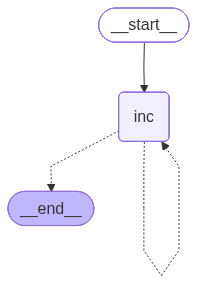

In [5]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())